# **NOTEBOOK FOR MACHINE LEARNING PROJECT**

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Importing Necessary Librarires**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import img_to_array,load_img
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam, SGD, Adadelta, Adamax
from keras.metrics import categorical_crossentropy
from keras.models import load_model
from PIL import Image, ImageFile
from matplotlib import pyplot as plt
from keras.applications import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
ImageFile.LOAD_TRUNCATED_IMAGES = True
tf.test.gpu_device_name()

'/device:GPU:0'

**Providing the Train and Test image paths**

In [ ]:
train_path = '/kaggle/input/waste-pictures/train'
test_path = '/kaggle/input/waste-pictures/test'

## **Data Preprocessing with some basic augmentation and preparing the images for input**

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 128

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   zoom_range = 0.3, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=30, 
                                  zoom_range = 0.3, 
                                  width_shift_range=0.2,
                                  height_shift_range=0.2, 
                                  horizontal_flip = 'true')

In [ ]:
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(test_path, 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical')

Found 17872 images belonging to 34 classes.
Found 5756 images belonging to 34 classes.


**Creating the labels.txt file which will be used in the Application**

In [ ]:
print(train_generator.class_indices)
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt','w') as f:
    f.write(labels)

{'XLight': 0, 'bandaid': 1, 'battery': 2, 'bowlsanddishes': 3, 'bread': 4, 'bulb': 5, 'cans': 6, 'carton': 7, 'chopsticks': 8, 'cigarettebutt': 9, 'diapers': 10, 'facialmask': 11, 'glassbottle': 12, 'leaflet': 13, 'leftovers': 14, 'medicinebottle': 15, 'milkbox': 16, 'nailpolishbottle': 17, 'napkin': 18, 'newspaper': 19, 'nut': 20, 'penholder': 21, 'pesticidebottle': 22, 'plasticbag': 23, 'plasticbottle': 24, 'plasticene': 25, 'rag': 26, 'tabletcapsule': 27, 'thermometer': 28, 'toothbrush': 29, 'toothpastetube': 30, 'toothpick': 31, 'traditionalChinesemedicine': 32, 'watermelonrind': 33}


# **VGG16**

**Defining the VGG16 model which is pretrained using Imagenet Weights**

In [ ]:
base_model_vgg16= tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
    classes=1000
)
base_model_vgg16.trainable = False

model_vgg16 = tf.keras.Sequential([
    base_model_vgg16,
    tf.keras.layers.Conv2D(64,3,activation = 'relu'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(34,activation = 'softmax')
])

58889256/58889256 [==============================] - 0s 0us/step


**Setting optimizers and learning rates**

In [ ]:
modified_Adam = keras.optimizers.Adam(learning_rate=0.0001)
model_vgg16.compile(loss='categorical_crossentropy',
              optimizer=modified_Adam,
              metrics=['accuracy'])

In [ ]:
model_vgg16.summary()
print('Base Model Layers:',len(base_model_vgg16.layers))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          294976    
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 34)                2210      
                                                                 
Total params: 15,011,874
Trainable params: 297,186
Non-trainable params: 14,714,688
______________________________________

**Defining Fine tuning layers**

In [ ]:
base_model_vgg16.trainable = True
fine_tune_layer = 15
for layers in base_model_vgg16.layers[:fine_tune_layer]:
    layers.trainable = False

**Fitting and Training the Model**

In [ ]:
epochs = 25
history_vgg16 = model_vgg16.fit_generator(train_generator, 
                    shuffle = True,
                    epochs = epochs, 
                    validation_data = test_generator)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/25
  6/140 [>.............................] - ETA: 5:10 - loss: 3.5926 - accuracy: 0.0339

/opt/conda/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:845: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


140/140 [==============================] - 569s 4s/step - loss: 2.8729 - accuracy: 0.2686 - val_loss: 2.5538 - val_accuracy: 0.3553
Epoch 2/25
140/140 [==============================] - 457s 3s/step - loss: 2.1662 - accuracy: 0.4479 - val_loss: 2.1760 - val_accuracy: 0.4427
Epoch 3/25
140/140 [==============================] - 459s 3s/step - loss: 1.9069 - accuracy: 0.4900 - val_loss: 1.9722 - val_accuracy: 0.4785
Epoch 4/25
140/140 [==============================] - 460s 3s/step - loss: 1.7695 - accuracy: 0.5166 - val_loss: 1.8613 - val_accuracy: 0.5045
Epoch 5/25
140/140 [==============================] - 458s 3s/step - loss: 1.6740 - accuracy: 0.5388 - val_loss: 1.7797 - val_accuracy: 0.5165
Epoch 6/25
 49/140 [=========>....................] - ETA: 3:37 - loss: 1.6134 - accuracy: 0.5551

**Plotting Training, Testing Loss and Accuracy**

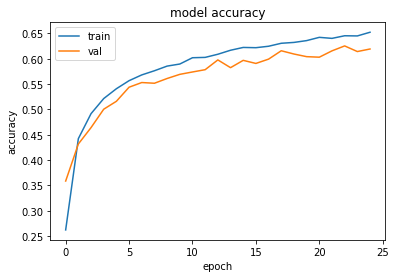

In [ ]:
plt.plot(history_vgg16.history['acc'])
plt.plot(history_vgg16.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

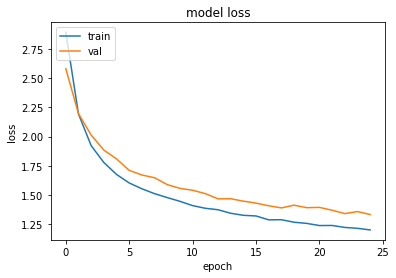

In [ ]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Saving our trained Models**

In [ ]:
model_vgg16.save('model_vgg16.h5')